## Imports & loading the row training data + test data
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

yamen_data_folder_path = r'C:\Users\yamen\OneDrive\Desktop\DA151X KEX-arbete for DATA\kaggle\ieee-fraud-detection'
oscar_data_folder_path = r''

data_folder_path = yamen_data_folder_path

df_train_transaction = pd.read_csv(data_folder_path + r'\train_transaction.csv')
#df_train_identity = pd.read_csv(your_data_folder_path + r'\train_identity.csv)

df_test_transaction = pd.read_csv(data_folder_path + r'\test_transaction.csv')
#df_test_identity = pd.read_csv(your_data_folder_path + r'\test_identity.csv')

C:\Users\yamen\AppData\Local\Temp\ipykernel_26968\2556936663.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## data preprocessing functions
---

In [9]:
# pass in the data frame as an argument to change all boolean columns to binary with type int8 to occupy less memory
def boolean_to_binary(df: pd.DataFrame):
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype('int8')
        # for columns with only two unique values
        elif df[col].dtype == 'object' and df[col].nunique() == 2:
            unique_values = df[col].unique()
            df[col] = df[col].apply(lambda x: 0 if x==unique_values[0] else 1 if x==unique_values[1] else np.nan)
 
    return df

# A pivvot table to be used in the object encoding functions. Diverse object columns EDA
def make_pivot(df:pd.DataFrame, index:str) -> pd.DataFrame:
    """..."""
    df[index] = df[index].fillna('NaN')
    df_pivot = df.pivot_table(index=index, columns='isFraud', aggfunc='size')
    df_pivot = df_pivot.fillna(0)
    df_pivot.columns = ['valid', 'fraud']
    df_pivot['count'] = df_pivot['valid'] + df_pivot['fraud']
    df_pivot[['valid_norm', 'fraud_norm']] = df_pivot[['valid', 'fraud']].div(other=df_pivot['count'], axis=0)
    df_pivot = df_pivot.sort_values(by='fraud_norm', ascending=False)
    return df_pivot

def product_cd_to_numeric(df: pd.DataFrame):
    pivot_prodcd = make_pivot(df, index='ProductCD')
    return df['ProductCD'].map(pivot_prodcd['fraud_norm'])
    

def card4_to_numeric(df: pd.DataFrame):
    pivot_card4 = make_pivot(df, index='card4')
    return df['card4'].map(pivot_card4['fraud_norm'])

def card6_to_numeric(df: pd.DataFrame):
    pivot_card6 = make_pivot(df, index='card6')
    return df['card6'].map(pivot_card6['fraud_norm'])

def m4_to_numeric(df: pd.DataFrame):
    pivot_m4 = make_pivot(df, index='M4')
    return df['M4'].map(pivot_m4['fraud_norm'])

# Could encode as hierarchical with (C, S, H, R, W, NaN) -> (5, 4, 3, 2, 1, 0)
def mail_doamain_to_numeric(df, columnName):
    pass




## visulalizing functions & settings
---

In [3]:
# Define ANSI escape codes for colors
color_red = '\033[31m'
color_green = '\033[32m'
color_yellow = '\033[33m'
color_blue = '\033[34m'
color_magenta = '\033[35m'
color_cyan = '\033[36m'
color_reset = '\033[0m'  # Reset color to default

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
#df_train_transaction.describe()

def describe_whole_df(df):
    for col in df.columns:
        values = df_train_transaction[col]
        num_uniques = values.nunique()
        
        # Data type of the column
        data_type = values.dtype
        
        # Number of NaN values
        num_nan = values.isnull().sum()
        
        # Number of non-NaN values
        num_non_nan = values.count()
        
        # Ratio of NaN values
        if num_non_nan > 0:
            nan_ratio = num_nan / (num_nan + num_non_nan)
        else:
            nan_ratio = np.nan
        
        print(color_cyan + f'Column: {col}' + color_reset)
        print(color_yellow + f'Data Type: {data_type}'+ color_reset)
        print(color_magenta+ f'Number of Unique Values: {num_uniques}'+ color_reset)
        print(color_red+ f'Number of NaN Values: {num_nan}'+ color_reset)
        print(color_green+ f'Number of Non-NaN Values: {num_non_nan}'+ color_reset)
        print(color_blue+ f'Ratio of NaN Values: {nan_ratio:.4f}\n'+ color_reset)
        
        print(f'Unique Values:')
        print(values.unique())
        
        # Plotting example (optional)
        if num_uniques <= 10:  # Plot only if number of unique values is reasonable
            plt.figure(figsize=(8, 4))
            if pd.api.types.is_numeric_dtype(values):
                sns.histplot(values.dropna(), bins=20, kde=True)
                plt.title(f'Histogram of {col}')
                plt.xlabel(col)
                plt.ylabel('Frequency')
            else:
                value_counts = values.value_counts()
                sns.barplot(x=value_counts.index, y=value_counts.values)
                plt.title(f'Bar plot of {col}')
                plt.xlabel(col)
                plt.ylabel('Count')
                plt.xticks(rotation=45)
            plt.show()
        print('\n --------------------------------------------NEXT FEATURE---------------------------------------------\n')

def describe_df_with_columns(df,list_of_columns):
    for col in list_of_columns:
        values = df[col]
        num_uniques = values.nunique()
        if num_uniques <= 2:
            continue
        data_type = values.dtype
        num_nan = values.isnull().sum()
        num_non_nan = values.count()
        if num_non_nan > 0:
            nan_ratio = num_nan / (num_nan + num_non_nan)
        else:
            nan_ratio = np.nan
        print(color_cyan + f'Column: {col}' + color_reset)
        print(color_yellow + f'Data Type: {data_type}'+ color_reset)
        print(color_magenta+ f'Number of Unique Values: {num_uniques}'+ color_reset)
        print(color_red+ f'Number of NaN Values: {num_nan}'+ color_reset)
        print(color_green+ f'Number of Non-NaN Values: {num_non_nan}'+ color_reset)
        print(color_blue+ f'Ratio of NaN Values: {nan_ratio:.4f}\n'+ color_reset)
        print(f'Unique Values:')
        print(values.unique())
        if num_uniques <= 10:  # Plot only if number of unique values is reasonable
            plt.figure(figsize=(8, 4))
            if pd.api.types.is_numeric_dtype(values):
                sns.histplot(values.dropna(), bins=20, kde=True)
                plt.title(f'Histogram of {col}')
                plt.xlabel(col)
                plt.ylabel('Frequency')
            else:
                value_counts = values.value_counts()
                sns.barplot(x=value_counts.index, y=value_counts.values)
                plt.title(f'Bar plot of {col}')
                plt.xlabel(col)
                plt.ylabel('Count')
                plt.xticks(rotation=45)
            plt.show()
        print('\n --------------------------------------------NEXT FEATURE---------------------------------------------\n')

## TEMP 

In [10]:
df_modified_train_transaction = boolean_to_binary(df_train_transaction)


Column: ProductCD
Data Type: object
Number of Unique Values: 5
Number of NaN Values: 0
Number of Non-NaN Values: 590540
Ratio of NaN Values: 0.0000

Unique Values:
['W' 'H' 'C' 'S' 'R']


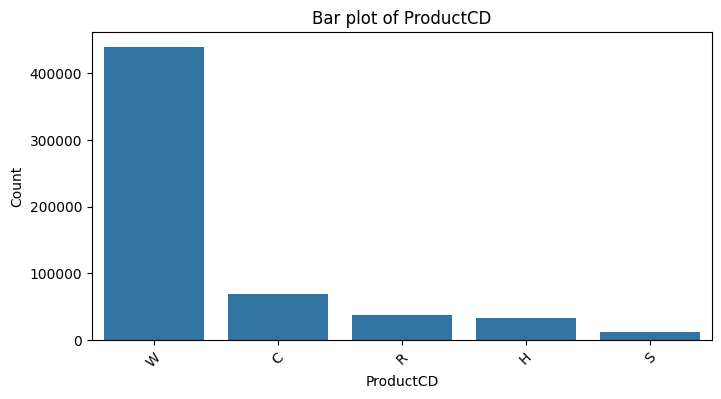


 --------------------------------------------NEXT FEATURE---------------------------------------------

Column: card4
Data Type: object
Number of Unique Values: 4
Number of NaN Values: 1577
Number of Non-NaN Values: 588963
Ratio of NaN Values: 0.0027

Unique Values:
['discover' 'mastercard' 'visa' 'american express' nan]


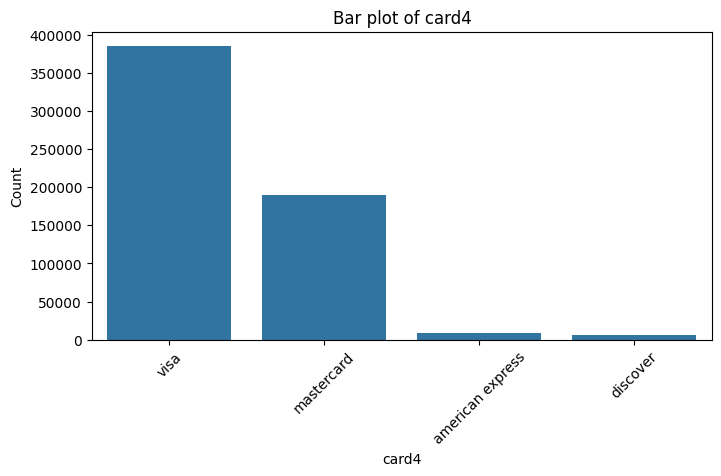


 --------------------------------------------NEXT FEATURE---------------------------------------------

Column: card6
Data Type: object
Number of Unique Values: 4
Number of NaN Values: 1571
Number of Non-NaN Values: 588969
Ratio of NaN Values: 0.0027

Unique Values:
['credit' 'debit' nan 'debit or credit' 'charge card']


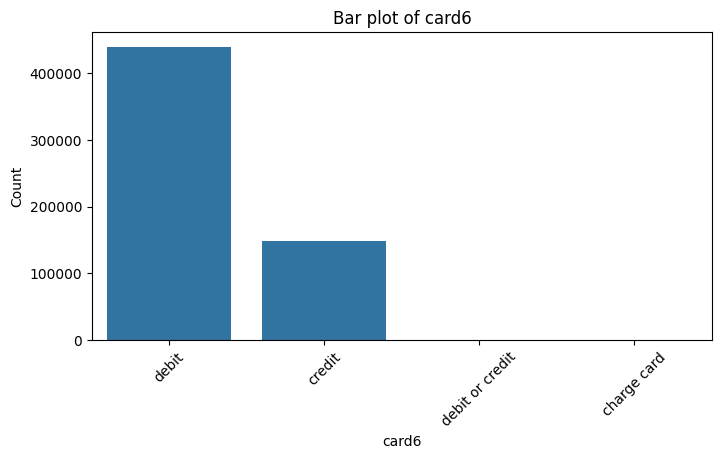


 --------------------------------------------NEXT FEATURE---------------------------------------------

Column: P_emaildomain
Data Type: object
Number of Unique Values: 59
Number of NaN Values: 94456
Number of Non-NaN Values: 496084
Ratio of NaN Values: 0.1599

Unique Values:
[nan 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com'
 'hotmail.com' 'verizon.net' 'aol.com' 'me.com' 'comcast.net'
 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com' 'prodigy.net.mx'
 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail' 'live.com' 'att.net'
 'juno.com' 'ymail.com' 'sbcglobal.net' 'bellsouth.net' 'msn.com' 'q.com'
 'yahoo.com.mx' 'centurylink.net' 'servicios-ta.com' 'earthlink.net'
 'hotmail.es' 'cfl.rr.com' 'roadrunner.com' 'netzero.net' 'gmx.de'
 'suddenlink.net' 'frontiernet.net' 'windstream.net' 'frontier.com'
 'outlook.es' 'mac.com' 'netzero.com' 'aim.com' 'web.de' 'twc.com'
 'cableone.net' 'yahoo.fr' 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net'
 'live.fr' 'yahoo.co.uk' 

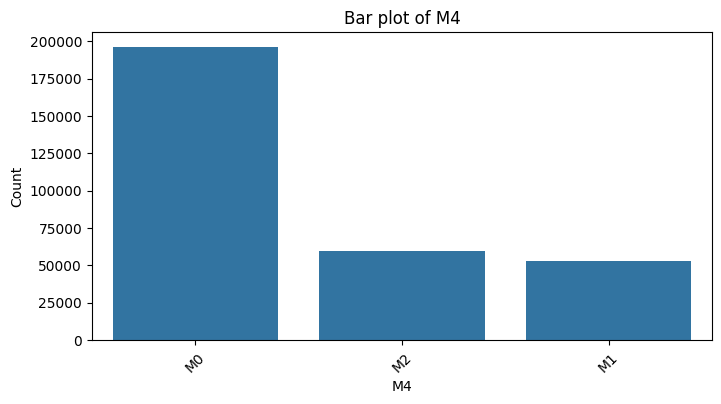


 --------------------------------------------NEXT FEATURE---------------------------------------------



In [5]:
df_categorical = df_train_transaction.select_dtypes(include=[object])

features_to_work_with = [
"ProductCD", #NOTE: ProductCD W is assosiated only with the transaction data
"card4",
"card6",
"P_emaildomain",
"R_emaildomain",
"M1",
"M2",
"M3",
"M4",
"M5",
"M6",
"M7",
"M8",
"M9",
]

describe_df_with_columns(df_modified_train_transaction,features_to_work_with)
